# Two-Sample Hypothesis Testing

We have learned a lot thus far about graph statistics, and now we want to apply some of that knowledge to doing two-sample graph testing. Imagine you are part of an alien race called the Moops. You live in harmony with another race, called the Moors, that look very similar to you, on the planet Zinthar. The evil overlord Zelu takes a random number of Moops and Moors and puts them on an island. You want to find your fellow Moops, but the Moops and Moors look very similar to each other. The one difference between the groups is that if you had an MRI machine, there is a difference between the scans of Moops and Moors. Lucky for you, you have an MRI machine on the island. What do you do?

This problem requires you to use two-sample testing on graphs. There are two types of tests that you can perform The first is given two graphs, and their corresponding latent positions, are their positions the same? Or, we can ask, are the distributions of the latent positions the same? Before we learn how to perform these tests, we should go through what hypothesis testing is and how algorithms in `graspologic` answer these questions.



## Hypothesis Testing

Hypothesis testing is quite the daunting subject to explain, but it essentially boils down to it's name, testing hypotheses. We first need to fomulate a statistical model of what the data looks like. In general, that means making a few assumptions about how the data we observed came to be; in our case, we each sample is observed independently from the other, and that the probability of observing such data is identical for each data. This is what is known as independently and identically distributed (i.i.d.). We consider the distribution where our observations are sampled from as really anything. Our model could say that this distribution of a Gaussian, for example, in which case we would have to estimate the parameters of this Gaussian. This would be a **parametric model**. When we consider the distribution to be something else, called $F$, then we have a **nonparametric model**. Mathematically, we can write the above as follows: we are given data $X_1, \ldots, X_n$ (so, $n$ observations) sampled i.i.d. from $F$.

Now, we need to set up the actual test. When testing, we have two types of hypotheses, a null hypothesis and an alternative hypothesis. We generally test against the null hypothesis, so, in practice, the null hypothesis is one of "no effect" or "no difference". It is denoted by $H_0$. The alternative hypothesis, denoted by $H_A$ is generally what we believe. So, when performing hypothesis tests, we generally want to reject our null hypothesis, meaning that the general "accepted" belief of the model is not true, and our hypothesis is true. We can not always do that, in which case we do not necessarily accept the alternative hypothesis, but failr to reject the null hypothesis. This is because the lack of evidence from our data doesn't mean that the null hypothesis effect does not exist.

We won't given an exhaustive list of the types of hypothesis tests, since, quite frankly, there are a lot. So, here, we will focus on two common used ones: independence testing and two-sample testing. When performing indepdence testing, we are testing whether two random variables, $X$ and $Y$ are sampled independently from some joint distribution of $X$ and $Y$ (called $F_{XY}$) or not. In this case, $F_X$ is the distribution of $X$, and $F_Y$ is the distribution of $Y$. Specifially, this means

\begin{align*}
    H_0 &: F_{XY} = F_X F_Y \\
    H_A &: F_{XY} \neq F_X F_Y
\end{align*}

This is what is known as a general independence test. Here, the null hypothesis is the $X$ and $Y$ are independent (which means the joint distribution is equal to the product of the marginal distributions $F_X$ and $F_Y$). The alternative hypothesis is that $X$ and $Y$ are not independent (and so the joint distribution is not equal to the product of the marginal distributions). 

Another type of testing is two-sample testing. Here, we are testing whether the distribution of $X$ and $Y$ are the same or different. So, is $X$ has distribution $F_X$ and $Y$ has distribution $F_Y$, we are testing

\begin{align*}
    H_0 &: F_X = F_Y \\
    H_A &: F_X \neq F_Y
\end{align*}

This is known as a general two-sample testing. Here, the null hypothesis is that the distributions of $X$ and $Y$ are the same, and the alternative is that $X$ and $Y$ do not have the same distribution.

Now that we know what testing essentially is, how do we perform it? Well, we have independence tests and two-sample tests that actually perform the tests. When running any test, the minmum information we get is a test statistic and p-value. The test statistic tells you, given your data, whether or not you should reject the null hypothesis. Of course, the ranges of test statics are large and varied, some are between -1 and 1, some are between 0 and 1, etc. So, we need a crtical value for the test, and that tells us that if our test statistic is above this critical value, we should reject, and if our test statistic is below that value, we should reject.The value of the critical value depends on the test, can depend on the sample size, etc.

The p-value can be thought of as a way to gauge our confidence, like what is the probability that the result that we got occurs due to chance? Specifically, what is the probability that we observe statstics in our the distribution of our null hypothesis more extreme than our observed statistic? In general, we consider whether our p-value is greater than or less than 0.05; we reject the null hypothesis when the p-value is less than 0.05 and fail to reject the null hypothesis when our p-value is greater than 0.05. This basically allows us to say that we are 95\% conifident that our test results are not due to chance. It's worth noting that the threshold of 0.05 is fairly arbitray. Lower values like 0.01 and even 0.001 are also valid to use. This allows us to be even more confident in the results of our test. Changing the threshold involves rerunning the test, since it changes the p-value you get.

Sometimes, for certain tests, the p-value can be found finding the null distribution by estimating parameters of a distribution and computing the p-value that way. For the nonparametric model, which we end up using in our tests, we need another solution instead. So, we can estimate the null distribution using a permutation test. Here, we compute an observed test statistic. Then, we permute our data and recompute our test statistics a number of times. This permutation our data essentially estimates our null distribution. Then, we can compute our crtical value and p-value from this estimated null distribution. Of course, this process isn't perfect since it is an estimate of the null distribution and not the actual distribution, but it is the best that can be done.

## Latent Position Graph Testing

Now that we have introduded what hypothesis testing is specifically, we can go back to our example. Let's answer the first question: given two graphs, and their corresponding latent positions, are their latent positions the same?

First, let's input some relevant packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from graspologic.inference import latent_position_test, latent_distribution_test
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

%matplotlib inline

We previously discussed what a stochastic block model (SBM) was. Remember that an adjancy matrix is a matrix where each entry denotes a node's connection to another node. When the matrix is composed of "communities" or "blocks", where a node’s block membership in a graph determines its probability of connection to the other nodes in the graph. We embedded the graph using adjancy spectral embedding (ASE), visualized it using a pairplot.

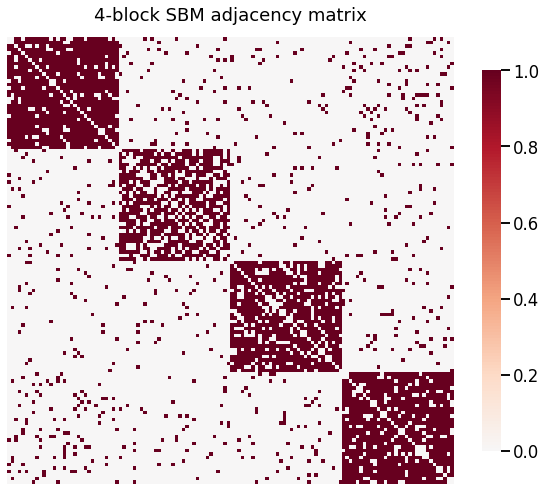

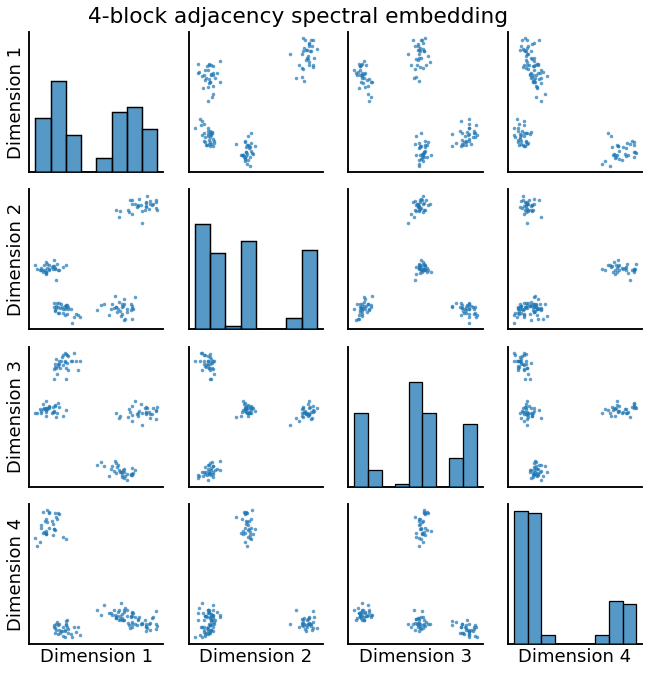

In [2]:
n_components = 4 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.11, 0.13, 0.2],
              [0, 0.7, 0.1, 0.1],
              [0, 0, 0.8, 0.1],
              [0, 0, 0, 0.85]])

P = symmetrize(P)
csize = [32] * 4
A = sbm(csize, P)
X = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A)
heatmap(A, title='4-block SBM adjacency matrix')
_ = pairplot(X, title='4-block adjacency spectral embedding')

In the adjacency matrix above, we can see a clearly defined block structure in the 4 communities in the graph. Below it, we see the adjancy spectral embedding (ASE). ASE is one such embedding procedures, and it allows us to estimate latent positions of the graph. Latent positions refer to the the ideas in random dot product graphs (RDPG).

For a graph with adjancy matrix $A$, the proability of an edge existing between two nodes is determined by a matrix $P$. We can represent P as $P = XX^T$, where $X$ is the latent positions of the graph. ASE allows us to obtain an estimate of these positions. Since, in the pairplot, we see 4 clusters of nodes corresponding to the 4 blocks, ASE is ablove to recover the positions and so RDPGs can model an SBM.

Now, we can estimate $X$ and sample two new RDPGs from the same latent positions:

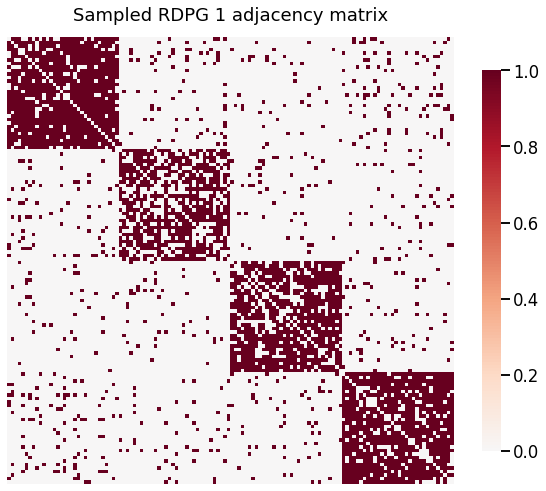

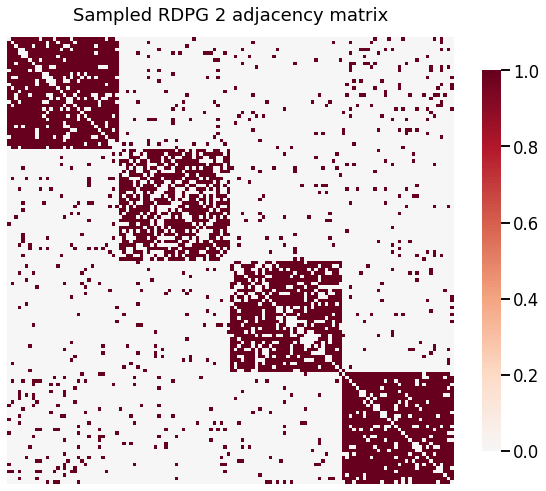

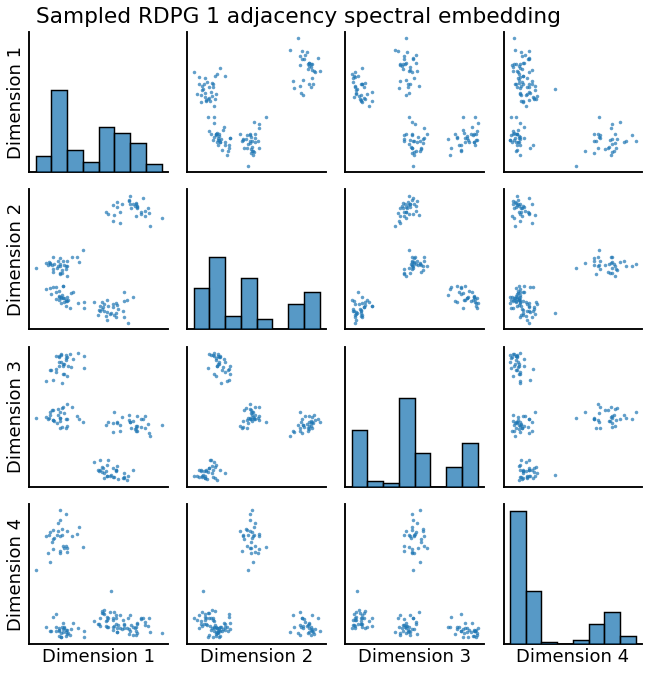

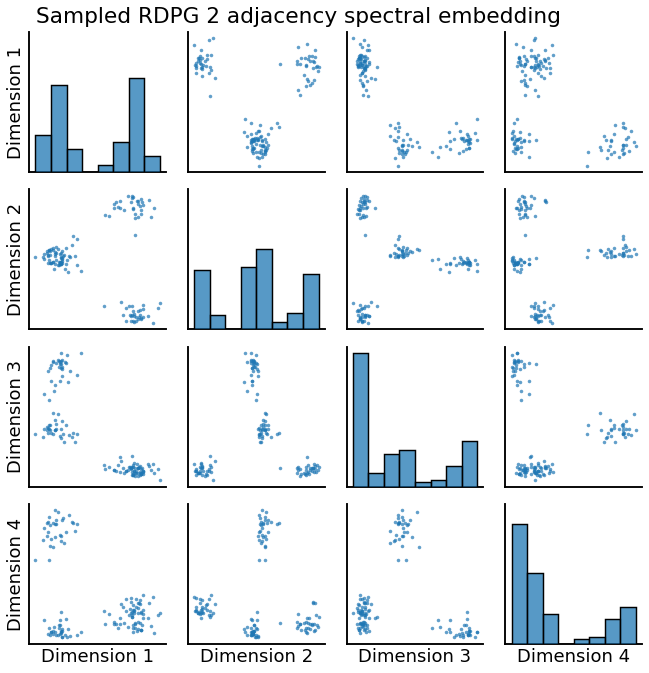

In [3]:
A1 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)
A2 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)

Xhat1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
Xhat2 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A2)

heatmap(A1, title='Sampled RDPG 1 adjacency matrix')
heatmap(A2, title='Sampled RDPG 2 adjacency matrix')
pairplot(Xhat1, title='Sampled RDPG 1 adjacency spectral embedding')
_ = pairplot(Xhat2, title='Sampled RDPG 2 adjacency spectral embedding')

Both the simulated RDPGs have 4 clear blocks and 4 clusters. Now, we must test whether or not they cam from the same latent positions.

Based on the way we simulated the graph, we know that our two inputs are sampled from the same latent positions. So, we can test whether or not the RDPGs are the same up to a rotation using `latent_position_test` in `graspologic`. So, we are testing,

\begin{align*}
    H_0 &: X_1 = X_2 R \\
    H_A &: X_1 \neq X_2 R
\end{align*}

So, are latent positions for graph 1 ($X_1$) and latent positions for graph 2 ($X_2$) the same (null) or different (alternative) up to a rotation. In this case, we know they are the same, so we expect the p-value to be high. Here, $R$ is an orthogonal rotaion matrix found from solving the orthogonal procrustes problem (we won't go over it in detail here). So, we run the test:

In [4]:
lpt = latent_position_test(A1, A2, n_bootstraps=1000, n_components=n_components)
print('p = {}'.format(lpt[0]))

p = 0.995004995004995


We see that the p-value is high, much greater than 0.05, and so this means that any observed differences between the latent positions of sampled RDPG 1 and 2 are likely due to chance.

Next, we can do the same test, except we add noise to one of the RDPGs. The matched test should have a low p-value and so we should reject the null hypothesis.

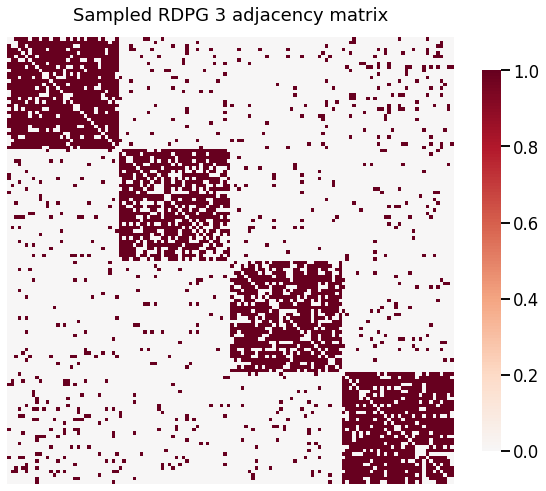

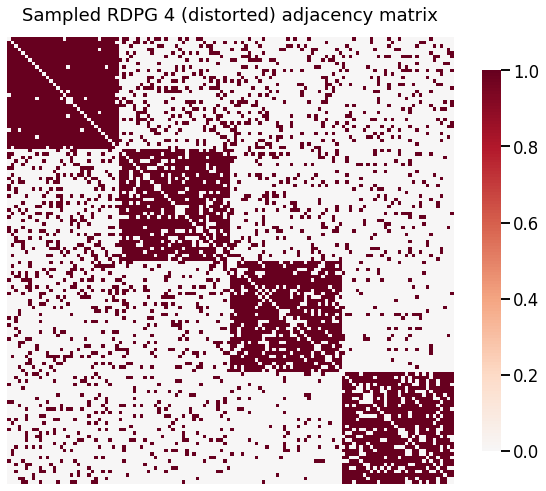

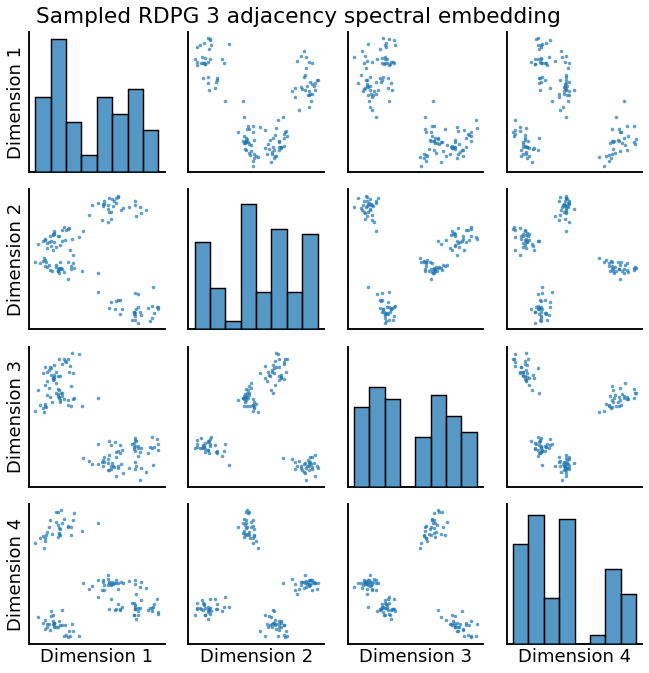

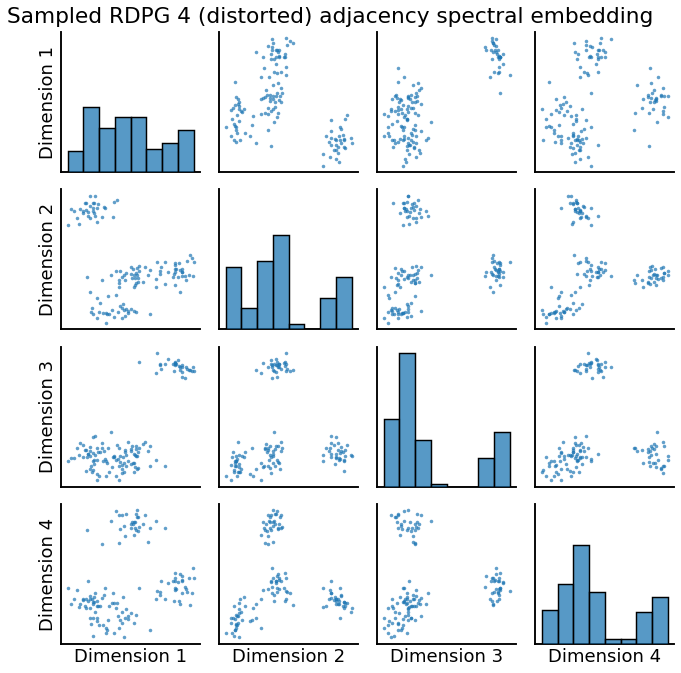

In [5]:
A3 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)
A4 = rdpg(X + np.random.normal(0.07, 0.02, size=(X.shape)),
          loops=False,
          rescale=False,
          directed=False)

Xhat3 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A3)
Xhat4 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A4)

heatmap(A3, title='Sampled RDPG 3 adjacency matrix')
heatmap(A4, title='Sampled RDPG 4 (distorted) adjacency matrix')
pairplot(Xhat3, title='Sampled RDPG 3 adjacency spectral embedding')
_ = pairplot(Xhat4, title='Sampled RDPG 4 (distorted) adjacency spectral embedding')

In [6]:
lpt = latent_position_test(A3, A4, n_bootstraps=1000, n_components=n_components)
print('p = {}'.format(lpt[0]))

p = 0.001998001998001998


We see that the p-value is high, less than 0.05, and so this means that any observed differences between the latent positions of sampled RDPG 1 and 2 are likely due to chance.

## Latent Distribution Two-Graph Testing

Now that we have introduded what hypothesis testing is specifically, we can go back to our example. Let's answer the first question: given two graphs, and their corresponding latent positions, are the distributions of their latent positions the same?

Let's generate a 2-block SBM and embed it with ASE like we did above.

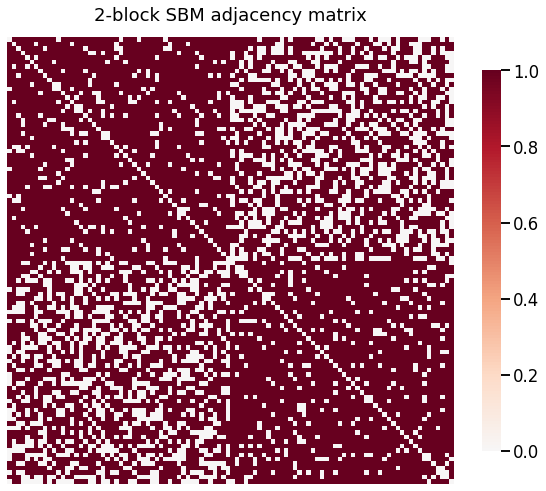

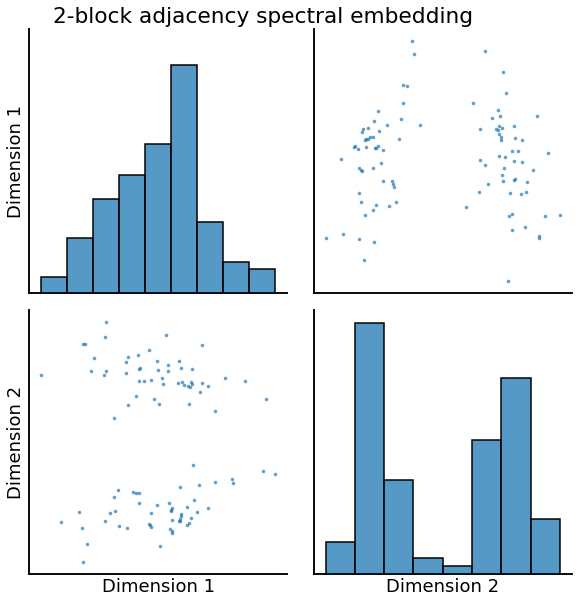

In [7]:
n_components = 2 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.6],
              [0.6, 0.9]])
csize = [50] * 2
A1 = sbm(csize, P)
X1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
heatmap(A1, title='2-block SBM adjacency matrix')
_ = pairplot(X1, title='2-block adjacency spectral embedding', height=4.5)

Next, we can generate a second SBM with a different number of vertices in each block, but the same probability matrix.

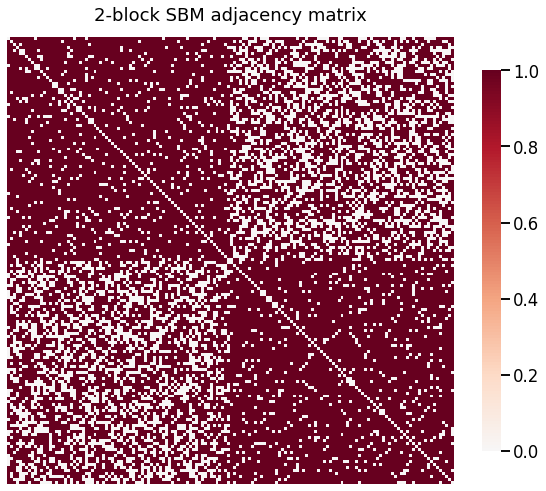

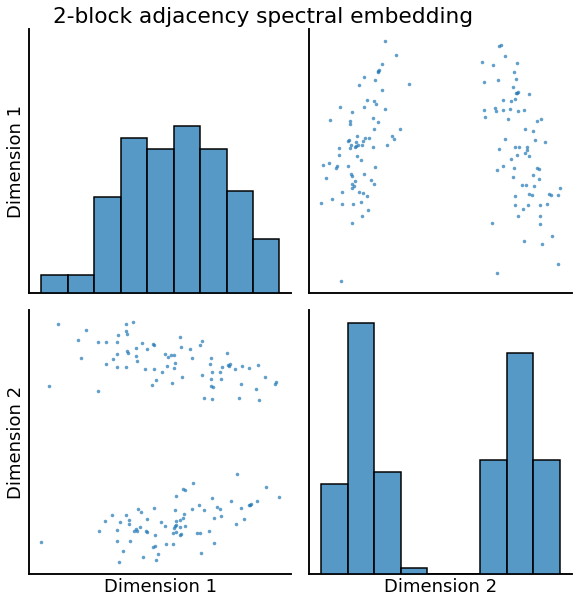

In [8]:
csize_2 = [75] * 2
A2 = sbm(csize_2, P)
X2 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A2)

heatmap(A2, title='2-block SBM adjacency matrix')
_ = pairplot(X2, title='2-block adjacency spectral embedding', height=4.5)

Here, we want to test whether the latent positions of the two graphs that we generated are from the same latent distribution. In other words, we are testing

\begin{align*}
    H_0 &: F_{X_1} = F_{X_2} Q \\
    H_A &: F_{X_1} \neq F_{X_2} Q
\end{align*}

where $F_{X_1}$ is the distribution of $X_1$ and $F_{X_2}$ is the distribution of $X_2$. $Q$ is the orthogonal rotation matrix, which is necessary since the test can give identical results up to a rotation. We then test using `latent_distribution_test` in `graspologic` on undirected graphs. In this first case, we know that the distributions of the two graphs should be the same, and so we would expect a high p-value.

Before we go into running the test, we have to talk about two independence tests, distance correlation (Dcorr), and multiscale graph correlation (MGC). These are powerful independence tests that operate really well on highly nonlinear and multivariate data. More information about those can be found in the `hyppo` package. Here, we plot the null distribution of the test statistics in blue, the test staitstc in red, and the p-value we get in the title.

In [9]:
ldt_dcorr = latent_distribution_test(A1, A2, test="dcorr", metric="euclidean", n_bootstraps=1000)

In [10]:
ldt_mgc = latent_distribution_test(A1, A2, test="mgc", metric="euclidean", n_bootstraps=1000)

In [11]:
print(ldt_dcorr[0], ldt_mgc[0])

0.7272727272727273 0.8461538461538461


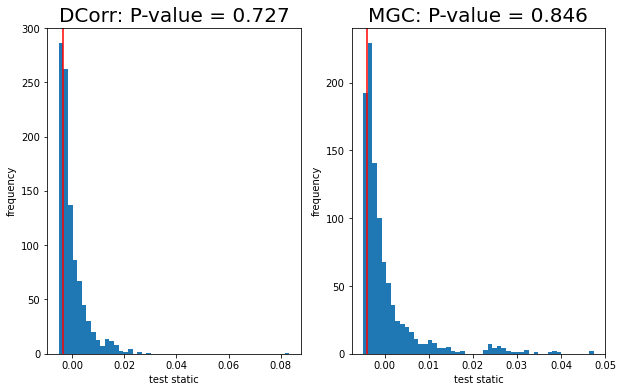

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(ldt_dcorr[2]['null_distribution'], 50)
ax[0].axvline(ldt_dcorr[1], color='r')
ax[0].set_title("DCorr: P-value = {:0.3f}".format(ldt_dcorr[0]), fontsize=20)
ax[0].set_xlabel("test static")
ax[0].set_ylabel("frequency")
ax[1].hist(ldt_mgc[2]['null_distribution'], 50)
ax[1].axvline(ldt_mgc[1], color='r')
ax[1].set_title("MGC: P-value = {:0.3f}".format(ldt_mgc[0]), fontsize=20)
ax[1].set_xlabel("test static")
ax[1].set_ylabel("frequency")
plt.show();

We see that while the test statistics are samal, the resulting p-value is above 0.05.  So, we fail to reject the null hypothesis that the two graphs come from the same generating distributions.

We can repeat the saem process when generate another SBM with a different interblock probability. We run the test again with the first graph and this new test:

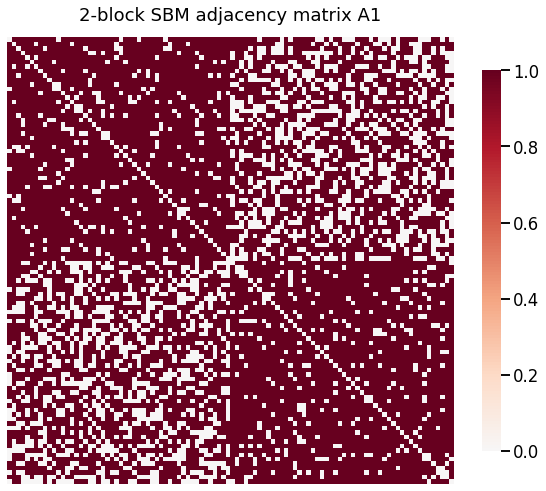

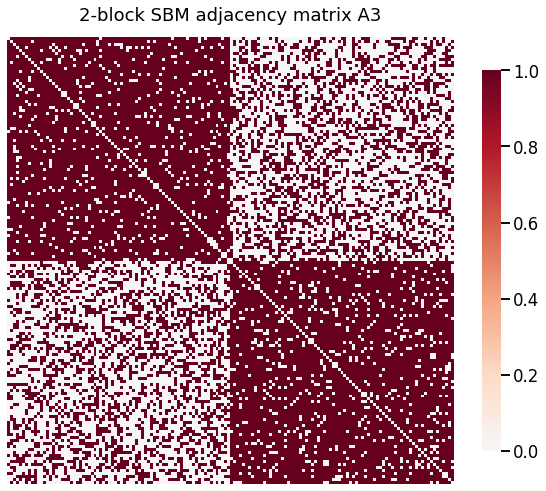

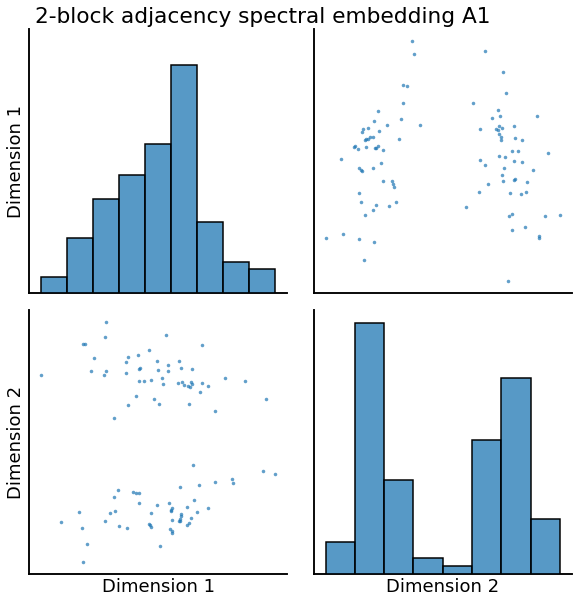

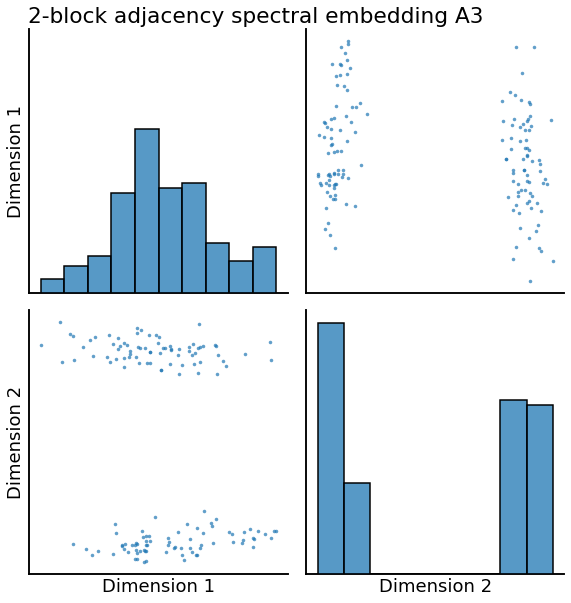

In [13]:
P2 = np.array([[0.9, 0.4],
               [0.4, 0.9]])

A3 = sbm(csize_2, P2)

X1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
X3 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A3)
heatmap(A1, title='2-block SBM adjacency matrix A1')
heatmap(A3, title='2-block SBM adjacency matrix A3')
pairplot(X1, title='2-block adjacency spectral embedding A1', height=4.5)
_ = pairplot(X3, title='2-block adjacency spectral embedding A3', height=4.5)

We once again plot the null distribution as before:

In [14]:
ldt_dcorr = latent_distribution_test(A1, A3, test="dcorr", metric="euclidean", n_bootstraps=1000)

In [15]:
ldt_mgc = latent_distribution_test(A1, A3, test="mgc", metric="euclidean", n_bootstraps=1000)

In [16]:
print(ldt_dcorr[0], ldt_mgc[0])

0.002997002997002997 0.000999000999000999


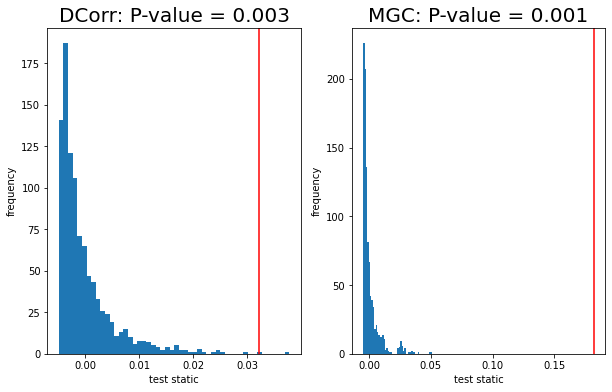

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(ldt_dcorr[2]['null_distribution'], 50)
ax[0].axvline(ldt_dcorr[1], color='r')
ax[0].set_title("DCorr: P-value = {:0.3f}".format(ldt_dcorr[0]), fontsize=20)
ax[0].set_xlabel("test static")
ax[0].set_ylabel("frequency")
ax[1].hist(ldt_mgc[2]['null_distribution'], 50)
ax[1].axvline(ldt_mgc[1], color='r')
ax[1].set_title("MGC: P-value = {:0.3f}".format(ldt_mgc[0]), fontsize=20)
ax[1].set_xlabel("test static")
ax[1].set_ylabel("frequency")
plt.show();

Thus, we have shown how to do latent position two sample position and distribution testing using methods in graspologic. Now, if you're ever stuck on a mysterious island with an alien race, and the only way to find you people is do MRI scans and latent positions two sample tests, you know what to do!